In [56]:
from guided_backprop import GuidedBackprop
from utils import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import imageio
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
checkpoint_path = '../../../data/models/20201021_unrestr_gaussian_resampled/'

In [3]:
# build model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(50)(x) 
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

keras_model = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

keras_model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.0005)

keras_model.compile(
    loss = 'mse',
    optimizer = adam_optimizer)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7efbf7bf6640> and <tensorflow.python.keras.layers.core.Dropout object at 0x7efbf7b13910>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7efcb922d5e0> and <tensorflow.python.keras.layers.core.Dropout object at 0x7efbf7b237f0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7efbf7b27df0> and <tensorflow.python.keras.layers.core.Dense object at 0x7efbf7aba4f0>).


In [39]:
guided_bprop = GuidedBackprop(keras_model)

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


In [40]:
img = imageio.imread(str('../../../data/commaai/train_bags_2/0/234_162run1.png')) 

In [41]:
img = cv2.resize(img, (291, 218))[76:142, 45:245,0:3]/255

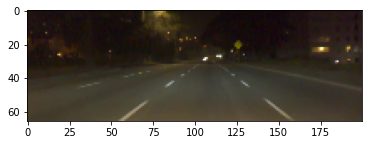

In [42]:
plt.imshow(img)

In [64]:
mask = guided_bprop.get_mask(img)               

In [66]:
mask = mask*20

In [46]:
masked = np.ma.masked_where(abs(mask) > 0.5, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


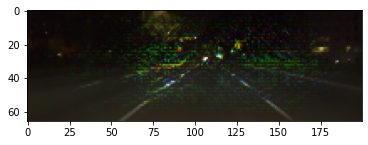

In [47]:
ax = plt.subplot()
plt.imshow(img, cmap='jet')
ax.imshow(masked, alpha=0.5, cmap = 'Reds')
#plt.imshow(mask*10, alpha = 0.7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


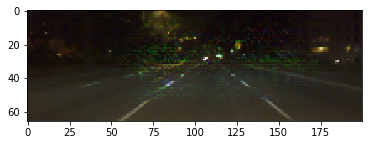

In [48]:
plt.imshow(img, interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.3)

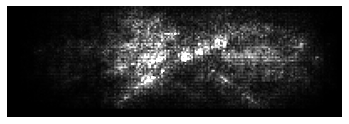

In [49]:
show_image(mask)  

In [34]:
from saliency import GradientSaliency
vanilla = GradientSaliency(keras_model)

In [35]:
mask = vanilla.get_mask(img)
show_image(mask, title='vanilla gradient')

InvalidArgumentError: input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node conv2d/Relu}}]]

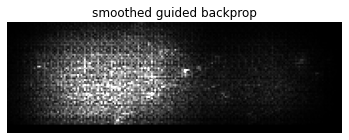

In [16]:
x = np.expand_dims(img, axis=0)
mask = guided_bprop.get_smoothed_mask(x[0])
show_image(mask,  title='smoothed guided backprop')

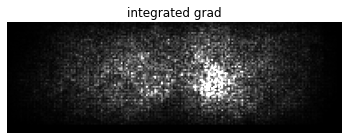

In [17]:
from integrated_gradients import IntegratedGradients
inter_grad = IntegratedGradients(keras_model)
mask = inter_grad.get_mask(x[0])
show_image(mask, title='integrated grad')

In [25]:
img_large = cv2.resize(img, (291, 218))

In [75]:
mask_large = np.zeros((218, 291,3))
mask_large[76:142, 45:245,0:3] = mask
mask_large_mod = mask_large.copy()
mask_large_mod[:, :,[0,2]] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


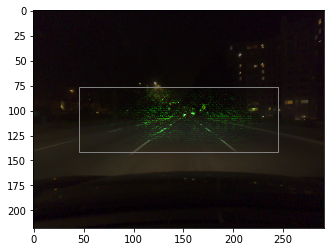

In [76]:
fig,ax = plt.subplots(1)
ax.imshow(img_large/255)
rect = patches.Rectangle((45,76),200,66,linewidth=1,edgecolor='grey',facecolor='none')
ax.imshow(mask_large_mod, alpha = 0.5)
ax.add_patch(rect)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


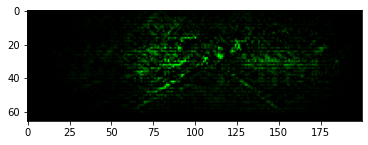

In [70]:
plt.imshow(mask_large_mod)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


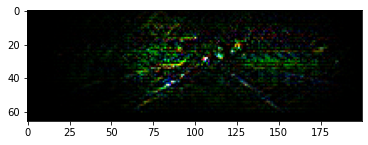

In [71]:
plt.imshow(mask)